In [1]:
# ! pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# ! pip install flax optax jetnet
# ! pip install flash_attention_jax
# ! pip install tensorflow-probability
# ! pip install --upgrade tensorflow

In [2]:
import sys
sys.path.append("../")

import jax
import jax.numpy as np
import optax
import flax
from flax.core import FrozenDict

import tensorflow as tf

# Ensure TF does not see GPU and grab all GPU memory
tf.config.set_visible_devices([], device_type='GPU')

from tqdm import tqdm, trange

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

from models.diffusion import VariationalDiffusionModel
from models.diffusion_utils import loss_vdm, sigma2, generate
from models.train_utils import create_input_iter, param_count, train_step

from jetnet.datasets import JetNet, TopTagging

%load_ext autoreload
%autoreload 2

## The `JetNet` data

In [3]:
num_particles = 30

particle_data, jet_data = JetNet.getData(jet_type=["q", "g"], data_dir="../data/", num_particles=num_particles)

# Normalize everything BUT the class (first element of `jet_data`

EPS = 1e-7

jet_data_mean = jet_data[:, 1:].mean(axis=(0,))
jet_data_std = jet_data[:, 1:].std(axis=(0,))
jet_data[:, 1:] = (jet_data[:, 1:] - jet_data_mean) / (jet_data_std + EPS)

# Remove cardinality; keep pT, eta, mass as jet features for conditioning on
jet_data = jet_data[:, :-1]

# Get mask (to specify varying cardinality) and particle features to be modeled (eta, phi, pT)
particle_mask = particle_data[:, :, -1]
particle_data = particle_data[:, :, :3]

[██████████████████████████████████████████████████] 100%


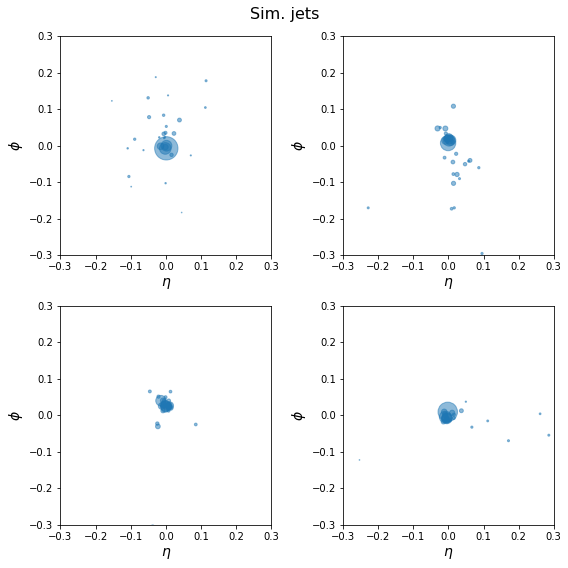

In [4]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8, 8))
gs = GridSpec(2, 2)

for i in range(4):
    
    ax = fig.add_subplot(gs[i])
    ax.scatter(*particle_data[i, :, :2].T, s=1000 * (particle_data[i, :, 2]), alpha=0.5)
    
    ax.set_xlabel(r"$\eta$", fontsize=14)
    ax.set_ylabel(r"$\phi$", fontsize=14)
    
    ax.set_xlim(-0.3, 0.3)
    ax.set_ylim(-0.3, 0.3)
    
plt.suptitle("Sim. jets", fontsize=16)
plt.tight_layout()

In [6]:
batch_size = 256
n_train = len(particle_data)

train_ds = tf.data.Dataset.from_tensor_slices((particle_data, jet_data, particle_mask))
train_ds = train_ds.cache()
train_ds = train_ds.repeat()

batch_dims=[jax.local_device_count(), batch_size // jax.device_count()]

for batch_size in reversed(batch_dims):
      train_ds = train_ds.batch(batch_size, drop_remainder=False)

train_ds = train_ds.shuffle(n_train, seed=42)

## Instantiate and train model

In [7]:
transformer_dict = FrozenDict({"d_model":256, "d_mlp":512, "n_layers":4, "n_heads":4})  # Transformer args

vdm = VariationalDiffusionModel(
          n_layers=3,
          d_embedding=3,
          d_hidden_encoding=16,
          timesteps=0, 
          d_t_embedding=32,
          d_feature=3,
          transformer_dict=transformer_dict,
          n_classes=2,
          embed_context=True,
          noise_schedule="learned_linear",
          gamma_min=-8.,
          gamma_max=14.,
          use_encdec=False)

In [8]:
# Past a test batch through to initialize model

n_smoke = 4

batch = np.array(particle_data[:n_smoke])
conditioning = np.zeros((n_smoke, jet_data.shape[-1]))
mask = np.array(particle_mask[:n_smoke])

rng = jax.random.PRNGKey(42)
out, params = vdm.init_with_output({"sample": rng, "params": rng}, batch, np.ones_like(conditioning), mask);

In [9]:
print(f"Params: {param_count(params):,}")

Params: 266,994


In [10]:
# Evaluate the loss for good measure
loss_vdm(params, vdm, rng, batch, np.zeros_like(conditioning), mask)

Array(8.98977, dtype=float32)

In [14]:
train_steps = 30_000

schedule = optax.warmup_cosine_decay_schedule(init_value=0.0, peak_value=3e-4, warmup_steps=1000, decay_steps=train_steps)
opt = optax.adamw(learning_rate=schedule, weight_decay=1e-4)

In [15]:
from functools import partial

In [16]:
@partial(jax.pmap, axis_name="batch", static_broadcasted_argnums=(3, 4))
def train_step(state, batch, rng, model, loss_fn):
    """Train for a single step."""
    x, conditioning, mask = batch
    loss, grads = jax.value_and_grad(loss_fn)(state.params, model, rng, x, conditioning, mask)
    grads = jax.lax.pmean(grads, "batch")
    new_state = state.apply_gradients(grads=grads)
    metrics = {"loss": jax.lax.pmean(loss, "batch")}
    return new_state, metrics

In [17]:
from flax.training import train_state

batches = create_input_iter(train_ds)
        
state = train_state.TrainState.create(apply_fn=vdm.apply, params=params, tx=opt)
pstate = replicate(state)

with trange(train_steps) as steps:
    for step in steps:

        rng, *train_step_rng = jax.random.split(rng, num=jax.local_device_count() + 1)
        train_step_rng = np.asarray(train_step_rng)

        pstate, metrics = train_step(pstate, next(batches), train_step_rng, vdm, loss_vdm)
        steps.set_postfix(val=unreplicate(metrics["loss"]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [09:09<00:00, 54.63it/s, val=-5.4541264]


## Conditional generation

For simplicity, let's just condition the model on random $(\mathrm{type}, p_T, \eta, M)$ from the training set.

In [18]:
import numpy as vnp

n_samples = 4000
idx_rnd = vnp.random.choice(vnp.arange(len(jet_data)), size=n_samples, replace=False)

cond = jet_data[idx_rnd]
mask = particle_mask[idx_rnd]

x_samples = generate(vdm, unreplicate(pstate).params, rng, (n_samples, num_particles), cond, mask=mask, steps=300)
x_samples = x_samples.mean() * mask[:, :, None]

/n/home11/smsharma/.local/lib/python3.9/site-packages/matplotlib/collections.py:981: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


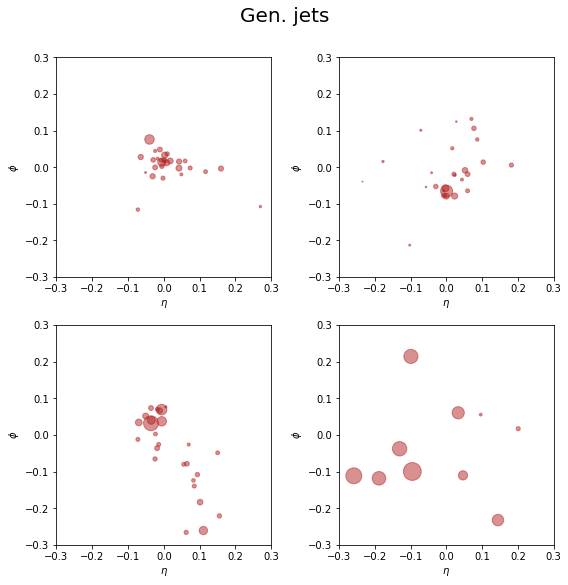

In [19]:
fig = plt.figure(figsize=(8, 8))
gs = GridSpec(2, 2)

for i in range(4):
    
    ax = fig.add_subplot(gs[i])
    
    ax.scatter(*x_samples[i, :, :2].T, s=1000 * (x_samples[i, :, 2]), alpha=0.5, color="firebrick")
            
    ax.set_xlabel(r"$\eta$")
    ax.set_ylabel(r"$\phi$")
    
    ax.set_xlim(-0.3, 0.3)
    ax.set_ylim(-0.3, 0.3)
    
plt.suptitle("Gen. jets", fontsize=20, y=1.01)
plt.tight_layout()

## Evaluate

Compare summaries between genreated and training samples.

In [20]:
# idx_rnd = vnp.random.choice(vnp.arange(len(jet_data)), size=n_samples, replace=False)
x = particle_data[idx_rnd] * particle_mask[idx_rnd, :, None]

In [21]:
import energyflow as ef

def jet_masses(jets_ary):
    jets_p4s = ef.p4s_from_ptyphims(jets_ary)
    masses = ef.ms_from_p4s(jets_p4s.sum(axis=1))
    return masses

def jet_ys(jets_ary):
    jets_p4s = ef.p4s_from_ptyphims(jets_ary)
    ys = ef.ys_from_p4s(jets_p4s.sum(axis=1))
    return ys

def jet_etas(jets_ary):
    jets_p4s = ef.p4s_from_ptyphims(jets_ary)
    etas = ef.etas_from_p4s(jets_p4s.sum(axis=1))
    return etas

def jet_phis(jets_ary):
    jets_p4s = ef.p4s_from_ptyphims(jets_ary)
    phis = ef.phis_from_p4s(jets_p4s.sum(axis=1), phi_ref=0)
    return phis

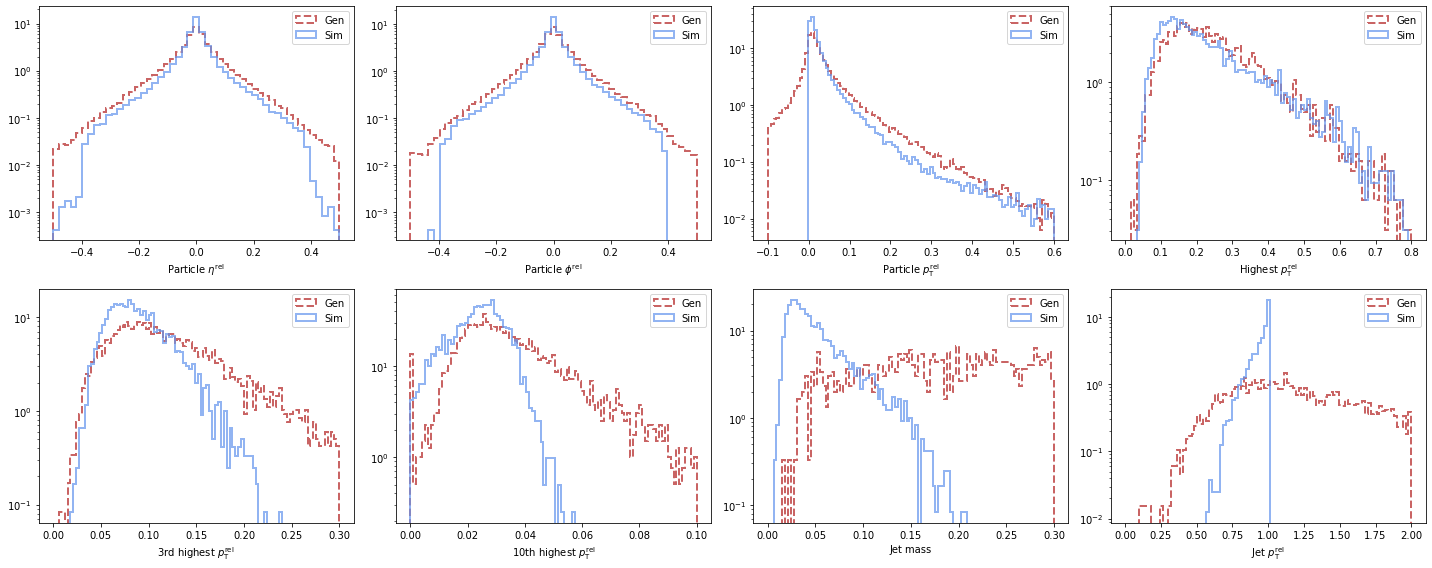

In [22]:
color_sim = "cornflowerblue"
color_gen = "firebrick"

fig = plt.figure(figsize=(20, 8))
gs = GridSpec(2, 4)

x_samples = vnp.array(x_samples)
x = vnp.array(x)

x_samples[x == 0.] = -999.
x[x == 0.] = -999.

#####

ax = fig.add_subplot(gs[0])

i_feat = 0

bins= np.linspace(-0.5, 0.5, 50)
ax.hist((np.concatenate(x_samples))[:, i_feat], histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);

eta = np.concatenate((np.array(x)))[:, i_feat]
eta = eta[eta != 0.]
ax.hist(eta, histtype='step', density=True, bins=bins, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"Particle $\eta^\mathrm{rel}$")
ax.get_yaxis().set_ticklabels([])

ax.set_yscale("log")
ax.legend()

#####

ax = fig.add_subplot(gs[1])

i_feat = 1

bins= np.linspace(-0.5, 0.5, 50)
ax.hist((np.concatenate(x_samples))[:, i_feat], histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);

eta = (np.concatenate(np.array(x)))[:, i_feat]
eta = eta[eta != 0.]
ax.hist(eta, histtype='step', density=True, bins=bins, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"Particle $\phi^\mathrm{rel}$")
ax.get_yaxis().set_ticklabels([])

ax.set_yscale("log")
ax.legend()

#####

ax = fig.add_subplot(gs[2])

i_feat = 2

bins= np.linspace(-0.1, 0.6, 100)
ax.hist((np.concatenate(x_samples))[:, i_feat], histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);

eta = np.concatenate((np.array(x)))[:, i_feat]
eta = eta[eta != 0.]
ax.hist(eta, histtype='step', density=True, bins=bins, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"Particle $p_\mathrm{T}^\mathrm{rel}$")
ax.get_yaxis().set_ticklabels([])
ax.legend()

ax.set_yscale("log")
ax.legend()

x_samples[x == -999.] = 0.
x[x == -999.] = 0.

######

ax = fig.add_subplot(gs[3])

bins = np.linspace(0., 0.8, 100)
ax.hist(np.max(x_samples[:, :, 2], -1), histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);
ax.hist(np.max(x[:, :, 2], -1), histtype='step', bins=bins, density=True, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"Highest $p_\mathrm{T}^\mathrm{rel}$")
ax.set_yscale("log")
ax.legend()

######

ax = fig.add_subplot(gs[4])

bins = np.linspace(0., 0.3, 100)
ax.hist(np.sort(x_samples[:, :, 2])[:, -3], histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);
ax.hist(np.sort(x[:, :, 2])[:, -3], histtype='step', bins=bins, density=True, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"3rd highest $p_\mathrm{T}^\mathrm{rel}$")
ax.set_yscale("log")
ax.legend()

######

ax = fig.add_subplot(gs[5])

bins = np.linspace(0., 0.1, 100)
ax.hist(np.sort(x_samples[:, :, 2])[:, -10], histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);
ax.hist(np.sort(x[:, :, 2])[:, -10], histtype='step', bins=bins, density=True, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"10th highest $p_\mathrm{T}^\mathrm{rel}$")
ax.set_yscale("log")
ax.legend()

######

ax = fig.add_subplot(gs[6])

bins= np.linspace(0., 0.3, 100)

jet_mass = jet_masses(np.array([x_samples[:, :, 2], x_samples[:, :, 0], x_samples[:, :, 1]]).transpose(1,2,0))
ax.hist(jet_mass, histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);

jet_mass = jet_masses(np.array([x[:, :, 2], x[:, :, 0], x[:, :, 1]]).transpose(1,2,0))
ax.hist(jet_mass, histtype='step', bins=bins, density=True, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"Jet mass")
ax.set_yscale("log")
ax.legend()

######

ax = fig.add_subplot(gs[7])

bins= np.linspace(0., 2, 100)

ax.hist(np.abs(x_samples[:, :, 2]).sum(-1), histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);
ax.hist(np.abs(x[:, :, 2]).sum(-1), histtype='step', bins=bins, density=True, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"Jet $p_\mathrm{T}^\mathrm{rel}$")
ax.set_yscale("log")
ax.legend()

plt.tight_layout()